# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
experiment_name = 'explore_demand_test'

# load Java simulation data
experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder = fr'data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Analyse FD data
The freeway layout is chosen because of the bottleneck of the on-ramp. This should create disruptions to traffic which forces vehicles to change lanes and bring variety to car-following. Because of this, the bottleneck section of the freeway is analysed. Link BC contains the two main freeway lanes and the merging lane of the on-ramp: BC.LEFT, BC.RIGHT, and BC.ONRAMP.

In [14]:
# show scatter plot
def show_fd_scatter_plot_seeds(df, density_var, flow_var):
    # get seeds
    seeds = df['seed'].unique()

    # categorical colors for runs
    categorical_colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 
        'blue', 'darkorange', 'forestgreen', 'crimson', 'indigo',
        'saddlebrown', 'hotpink', 'dimgray', 'yellowgreen', 'deepskyblue',
        'slateblue', 'coral', 'lightseagreen', 'gold', 'orchid',
        'mediumslateblue', 'darkgoldenrod', 'lightcoral', 'royalblue', 'mediumvioletred',
        'darkkhaki', 'mediumaquamarine', 'darkturquoise', 'lightpink', 'teal',
        'rosybrown', 'mediumblue', 'peru', 'slategray', 'mediumorchid'
    ]

    # get color per run
    unique_runs = df['run'].unique()
    run_to_color = {run: color for run, color in zip(unique_runs, categorical_colors)}

    # create plots
    n_columns = 2
    n_rows = (len(seeds) + 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, n_rows * 3))
    axes = axes.flatten()
    
    # loop through each seed
    for i, seed in enumerate(seeds):
        # get seed
        df_seed = df[df['seed'] == seed]

        # map colors based on run
        df_seed_colors = df_seed['run'].map(run_to_color)
        
        # plot seed data
        axes[i].scatter(df_seed[density_var], df_seed[flow_var], color=df_seed_colors, alpha=0.7)
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram for seed {seed}')
        
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()

def show_fd_scatter_plot_run(df, density_var, flow_var):
    # filter on single seed
    df_seed = df[df['seed'] == 0]

    # get all runs
    runs = df_seed['run'].unique()

    # create plots for all runs
    n_columns = 8
    n_rows = (len(runs) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(26, n_rows * 2))
    axes = axes.flatten()
    
    # print each seed seperately
    for i, run in enumerate(runs):
        # get run
        df_run = df_seed[df_seed['run'] == run]
        
        # plot figure
        scatter = axes[i].scatter(df_run[density_var], df_run[flow_var], c=df_run['time'], cmap='viridis')
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram for run {run}')

        # set color bar
        fig.colorbar(scatter, ax=axes[i], label='Time [s]')
    
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Show plots
    plt.tight_layout()
    plt.show()

# add time column
def add_time_column(df, sample_interval):
    df['time'] = df.groupby(['seed', 'run']).cumcount() * sample_interval
    return df

# filter columns
def filter_columns(df, selected_variables):
    columns_to_include = [col for col in df.columns if col in selected_variables]
    df = df[columns_to_include]
    return df

# convert data
def convert_fd_data(df):
    df_converted = df.copy()
    for col in df_converted.columns.tolist():
        if 'flow' in col:
            df_converted[col] = df_converted[col].astype(float) * 3600
        if 'density' in col:
            df_converted[col] = df_converted[col].astype(float) * 1000
        if 'speed' in col:
            df_converted[col] = df_converted[col].astype(float) * 3.6
    return df_converted

In [32]:
# select merging lanes and required FD variables
variables = ['BC.LEFT_density', 'BC.LEFT_flow', 'BC.LEFT_speed',
             'BC.RIGHT_density', 'BC.RIGHT_flow', 'BC.RIGHT_speed',
             'BC.ONRAMP_density', 'BC.ONRAMP_flow', 'BC.ONRAMP_speed',
             'E2B.ONRAMP_density', 'E2B.ONRAMP_flow', 'E2B.ONRAMP_speed'
            ]

# get intermediate FD data
df_fd = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd = df_fd.dropna(subset=['BC.RIGHT_flow'])
# add time column, each FD calculation represents 30 sec
df_fd = add_time_column(df_fd, 30)
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
df_fd = filter_columns(df_fd, variables_of_interest)

display(df_fd.head(40))

,BC.LEFT_density,BC.LEFT_flow,BC.LEFT_speed,BC.RIGHT_density,BC.RIGHT_flow,BC.RIGHT_speed,BC.ONRAMP_density,BC.ONRAMP_flow,BC.ONRAMP_speed,E2B.ONRAMP_density,E2B.ONRAMP_flow,E2B.ONRAMP_speed,run,seed,main_demand,ramp_demand,time
0,NaN,0.000000,NaN,0.000688,0.019680,28.618831,0.000469,0.013369,28.476828,0.005895,0.085864,14.565235,0,0,3137.930781,722.174376,0
1,0.010571,0.340804,32.238866,0.024051,0.612354,25.460920,0.005016,0.131637,26.241568,0.018881,0.328095,17.376622,0,0,3137.930781,722.174376,30
2,0.015536,0.459456,29.572899,0.036241,0.631700,17.430385,0.007076,0.137072,19.371960,0.011587,0.204260,17.628440,0,0,3137.930781,722.174376,60
3,0.017475,0.454554,26.011197,0.038496,0.490835,12.750207,0.015285,0.177441,11.608625,0.014278,0.261360,18.304524,0,0,3137.930781,722.174376,90
4,0.019312,0.399887,20.706485,0.048033,0.441163,9.184557,0.026961,0.033574,1.245298,0.008413,0.136229,16.193483,0,0,3137.930781,722.174376,120
5,0.020039,0.405338,20.227843,0.047409,0.419277,8.843919,0.032674,0.097264,2.976849,0.013086,0.222846,17.029434,0,0,3137.930781,722.174376,150
6,0.023158,0.507101,21.897434,0.039725,0.515959,12.988345,0.053239,0.031694,0.595305,0.017823,0.280321,15.728426,0,0,3137.930781,722.174376,180
7,0.025255,0.529509,20.966467,0.035071,0.542102,15.457313,0.068000,0.034049,0.500722,0.028590,0.212991,7.449740,0,0,3137.930781,722.174376,210
8,0.029614,0.586995,19.821773,0.036834,0.477170,12.954545,0.061512,0.110706,1.799756,0.035960,0.077525,2.155890,0,0,3137.930781,722.174376,240
9,0.022210,0.465498,20.958787,0.079394,0.270111,3.402180,0.061360,0.064799,1.056042,0.027984,0.134041,4.789875,0,0,3137.930781,722.174376,270


In [16]:
# remove warm-up time
df_fd = df_fd[df_fd['time'] >= 500]

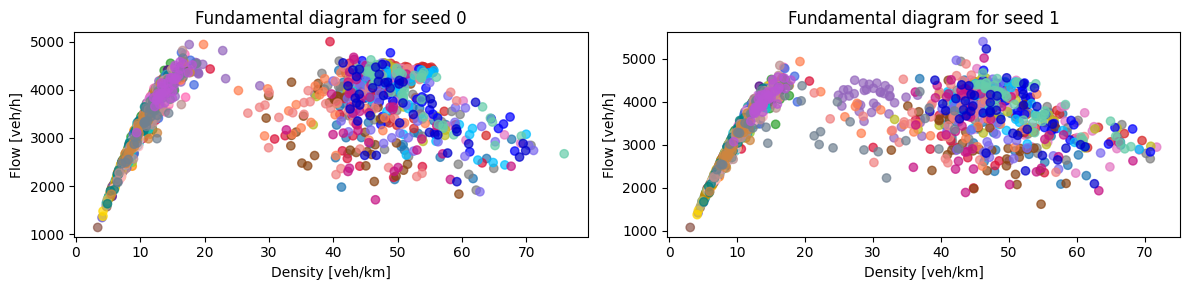

In [17]:
# combine road areas
df_fd_combined = pd.DataFrame()
df_fd_combined['time'] = df_fd['time']
df_fd_combined['main_demand'] = df_fd['main_demand']
df_fd_combined['ramp_demand'] = df_fd['ramp_demand']
df_fd_combined['BC_flow'] = df_fd['BC.LEFT_flow'] + df_fd['BC.RIGHT_flow'] + df_fd['BC.ONRAMP_flow']
df_fd_combined['BC_density'] = (df_fd['BC.LEFT_density'] + df_fd['BC.RIGHT_density'] + df_fd['BC.ONRAMP_density']) / 3
df_fd_combined['BC_speed'] = (df_fd['BC.LEFT_speed'] + df_fd['BC.RIGHT_speed'] + df_fd['BC.ONRAMP_speed']) / 3
df_fd_combined['E2B.ONRAMP_flow'] = df_fd['E2B.ONRAMP_flow']
df_fd_combined['E2B.ONRAMP_density'] = df_fd['E2B.ONRAMP_density']
df_fd_combined['E2B.ONRAMP_speed'] = df_fd['E2B.ONRAMP_speed']
df_fd_combined['seed'] = df_fd['seed']
df_fd_combined['run'] = df_fd['run']
    
df_new_fd = convert_fd_data(df_fd_combined)
show_fd_scatter_plot_seeds(df_new_fd, 'BC_density', 'BC_flow')

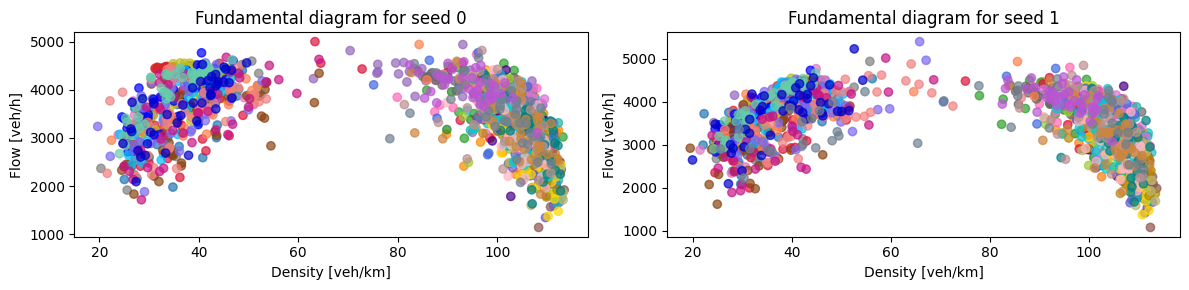

In [33]:
show_fd_scatter_plot_seeds(df_new_fd, 'BC_speed', 'BC_flow')

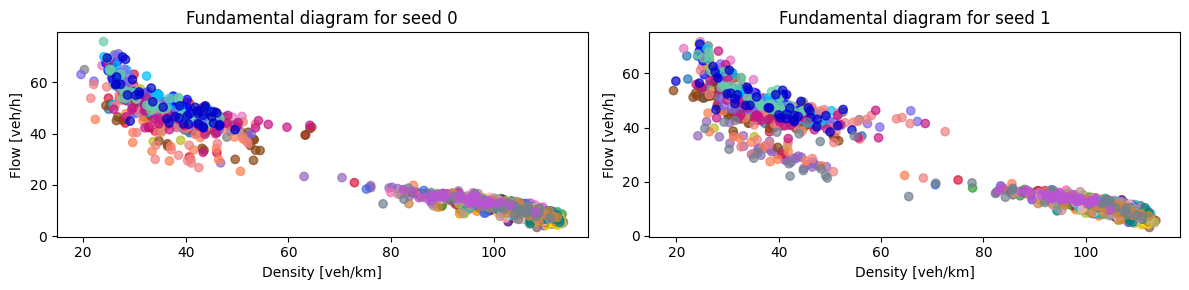

In [34]:
show_fd_scatter_plot_seeds(df_new_fd, 'BC_speed', 'BC_density')

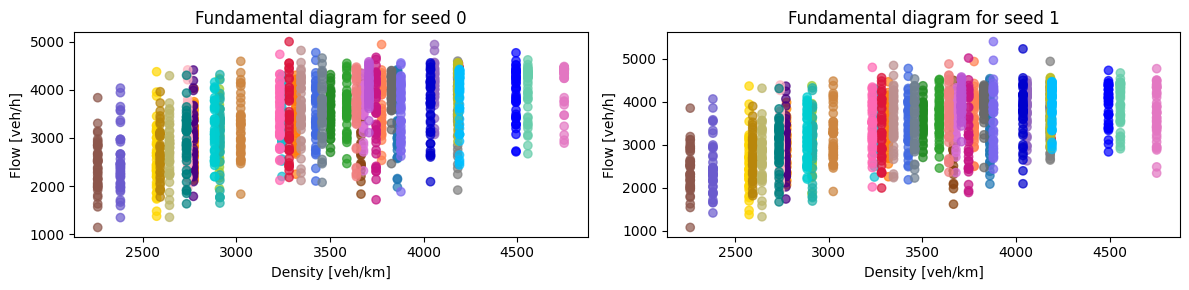

In [37]:
df_total_demand = df_new_fd.copy()
df_total_demand['total_demand'] = df_total_demand['main_demand'] + df_total_demand['ramp_demand']
show_fd_scatter_plot_seeds(df_total_demand, 'total_demand', 'BC_flow')

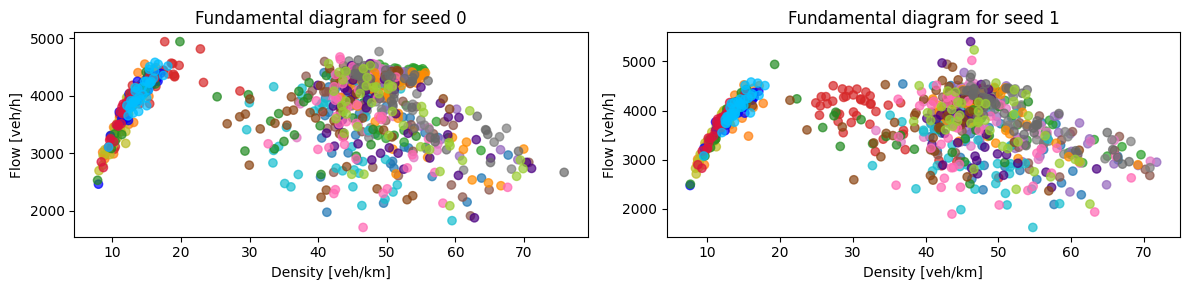

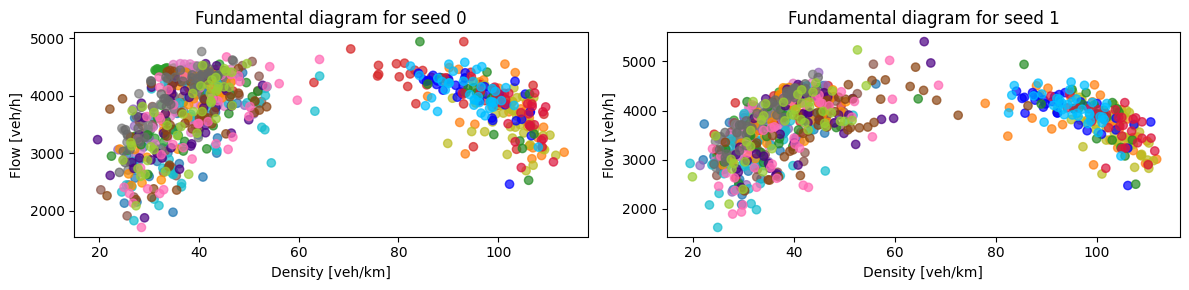

In [42]:
df_min_total_demand = df_total_demand[df_total_demand['total_demand'] > 3500]
show_fd_scatter_plot_seeds(df_min_total_demand, 'BC_density', 'BC_flow')
show_fd_scatter_plot_seeds(df_min_total_demand, 'BC_speed', 'BC_flow')

We see slight differences in FD data between the seeds. However, results look similar thus demand is leading for effects on FD.

Now, we will nof focus this research on one seed since the runs in each seeds have the same demand values. FDs of individual runs are analysed to identify whether they represent free-flow, saturated, or congested traffic. Afterwards, the other seeds will be incorporated to see how the identified runs look for that seed.

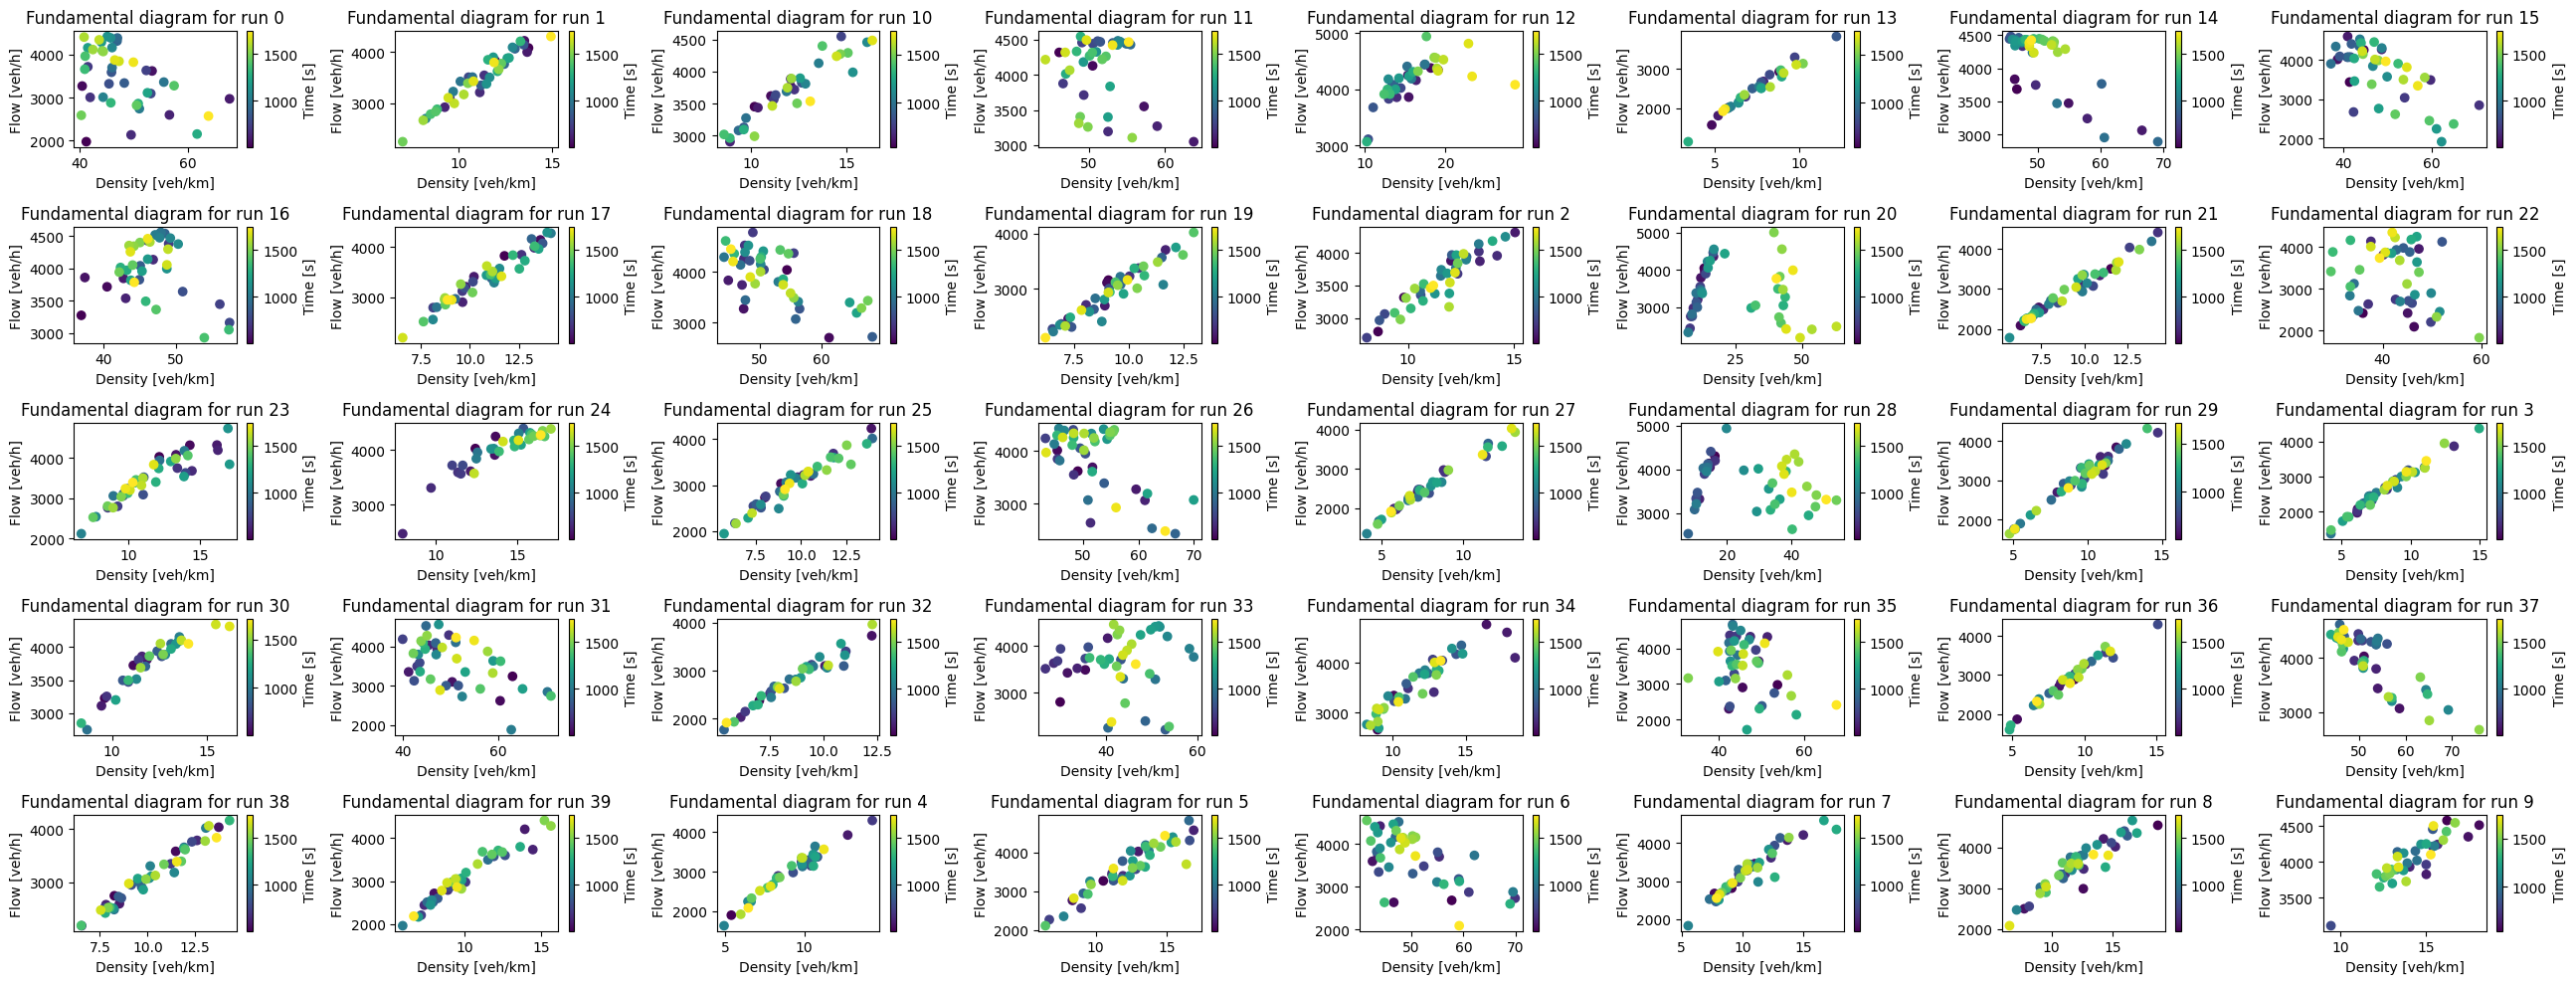

In [18]:
show_fd_scatter_plot_run(df_new_fd, 'BC_density', 'BC_flow')

Free-flow: 1, 2, 5, 9, 11, 12, 14, 16, 17, 18, 20, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 37, 38, 39
Congestion: 7, 10, 31, 36
Mixed or saturated: 0, 3, 4, 6, 8, 13, 15, 19, 21, 25, 27, 

In [19]:
# only include mixed or saturated runs
free_runs = [1, 2, 5, 9, 11, 12, 14, 16, 17, 18, 20, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 37, 38, 39]
con_runs = [7, 10, 31, 36]
sat_runs = [0, 3, 4, 6, 8, 13, 15, 19, 21, 25, 27]

df_all = df_new_fd[(df_new_fd['seed'] == 0) & (df_new_fd['run'].isin(sat_runs+con_runs+free_runs))]
df_sat = df_new_fd[(df_new_fd['seed'] == 0) & (df_new_fd['run'].isin(sat_runs))]
df_con = df_new_fd[(df_new_fd['seed'] == 0) & (df_new_fd['run'].isin(con_runs))]

# demand range for all runs
print('All runs:')
print("Main demand:", df_all['main_demand'].min(), " - ", df_all['main_demand'].max())
print("Ramp demand", df_all['ramp_demand'].min(), " - ", df_all['ramp_demand'].max())

# demand range for saturated or mixed runs
print('\nSaturated or mixed runs:')
print("Main demand:", df_sat['main_demand'].min(), " - ", df_sat['main_demand'].max())
print("Ramp demand", df_sat['ramp_demand'].min(), " - ", df_sat['ramp_demand'].max())

# demand range for saturated or mixed runs
print('\nCongested runs:')
print("Main demand:", df_con['main_demand'].min(), " - ", df_con['main_demand'].max())
print("Ramp demand", df_con['ramp_demand'].min(), " - ", df_con['ramp_demand'].max())

All runs:
Main demand: 2000.6785817806056  -  3995.1174291587
Ramp demand 108.22731331197588  -  799.3947838590988

Saturated or mixed runs:
Main demand: 2081.7529436801783  -  3504.9640175179484
Ramp demand 129.40097246560973  -  722.1743758980325

Congested runs:
Main demand: 2488.917274101296  -  3369.3244490562934
Ramp demand 154.30010877713516  -  655.0313042965013


In [20]:
# set box limits to filter FD values
def remove_fd_non_compliant_runs(df, density_column, flow_density, min_density_value, max_density_value, min_flow_value, max_flow_value):
    # identify runs with any data points outside the box
    non_compliant_runs = df[
        (df[density_column] <= min_density_value) | 
        (df[density_column] >= max_density_value) | 
        (df[flow_density] <= min_flow_value) | 
        (df[flow_density] >= max_flow_value)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered


# set box limits to filter FD values
def remove_demand_non_compliant_runs(df, min_main_value, max_main_value, min_ramp_value, max_ramp_value):
    # identify runs with any data points outside the box
    non_compliant_runs = df[
        (df['main_demand'] <= min_main_value) | 
        (df['main_demand'] >= max_main_value) | 
        (df['ramp_demand'] <= min_ramp_value) | 
        (df['ramp_demand'] >= max_ramp_value)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered

def remove_total_demand_non_compliant_runs(df, min_total_demand, max_total_demand):
    # identify runs with any data points outside the box
    df['total_demand'] = df['main_demand'] + df['ramp_demand']
    non_compliant_runs = df[
        (df['total_demand'] < min_total_demand) | 
        (df['total_demand'] > max_total_demand)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered

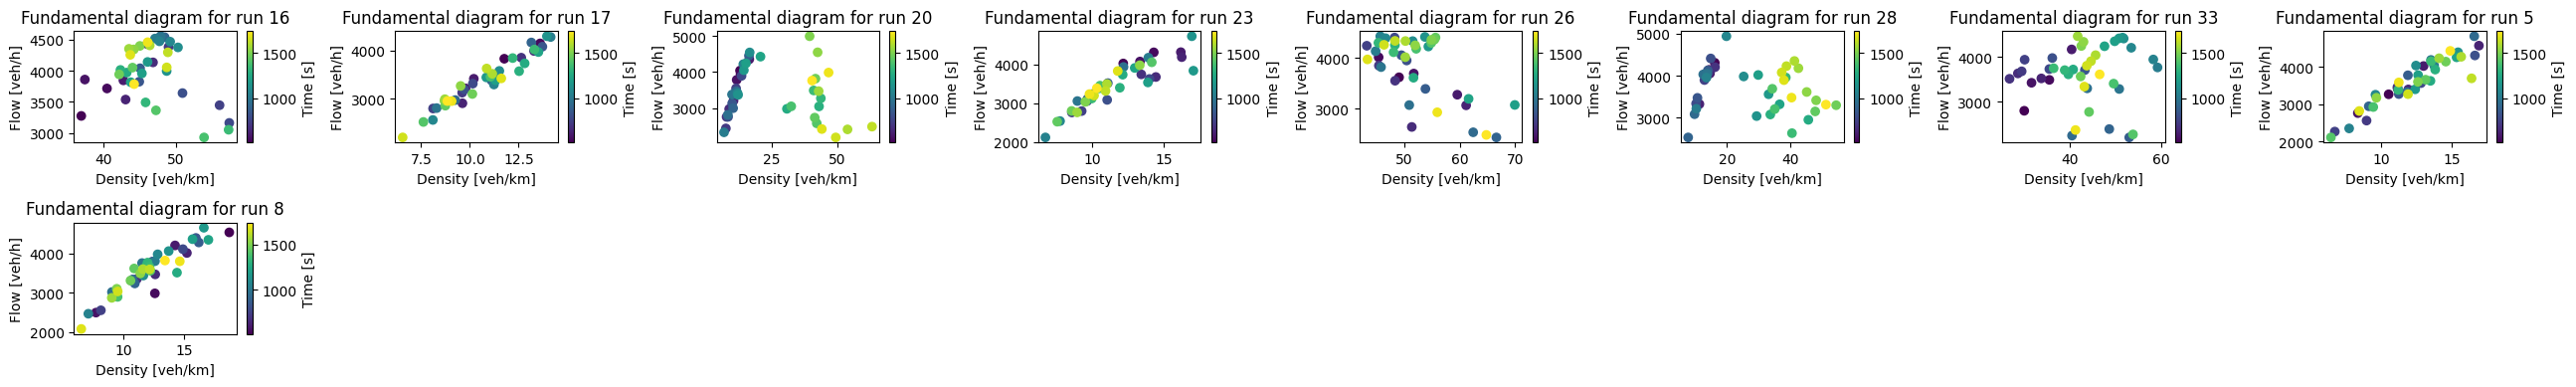

In [21]:
# use demand ranges
min_main = 2600
max_main = 4000
min_ramp = 400
max_ramp = 600
df_demand_ranges = remove_demand_non_compliant_runs(df_new_fd, min_main, max_main, min_ramp, max_ramp)
# plot these runs
show_fd_scatter_plot_run(df_demand_ranges, 'BC_density', 'BC_flow')

In [27]:
# print input values for main and ramp demand
def show_run_demand_input(df, run):
    df = df[df['seed'] == 0]
    print(f'Run {run}: main_demand={df.loc[df["run"] == run, "main_demand"].values[0]}, ramp_demand={df.loc[df["run"] == run, "ramp_demand"].values[0]}')

show_run_demand_input(df_new_fd, 20)
show_run_demand_input(df_new_fd, 17)

Run 20: main_demand=2687.534307060923, ramp_demand=594.3714348239621
Run 17: main_demand=2832.6570017898966, ramp_demand=410.9229148122777


So taking ranges from individual runs doe snot help since the majority of the selected runs is still free-flow.

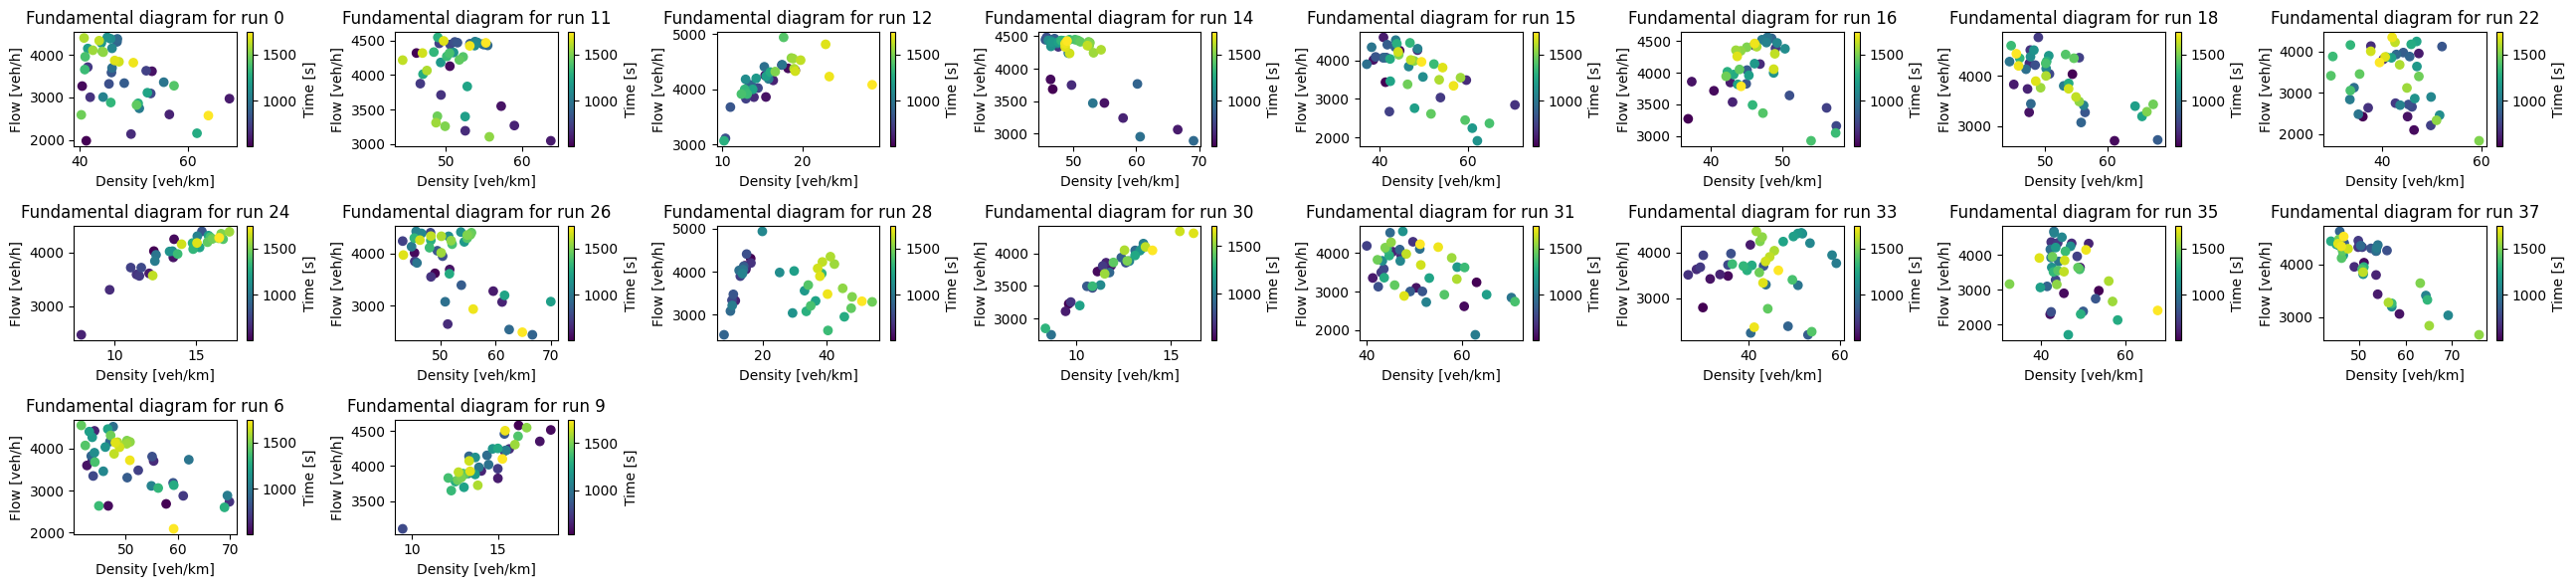

In [31]:
# filter for total demand
min_demand = 3600
max_demand = 5000
df_total_demand_ranges = remove_total_demand_non_compliant_runs(df_new_fd, min_demand, max_demand)
# plot these runs
show_fd_scatter_plot_run(df_total_demand_ranges, 'BC_density', 'BC_flow')

### 1.2 Analyse average FD data

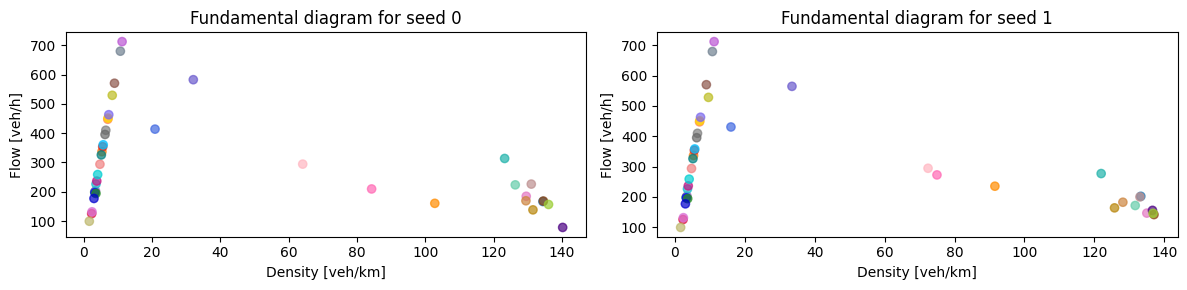

In [48]:
df_mean_values = df_new_fd.groupby(['seed', 'run'])[['E2B.ONRAMP_density', 'E2B.ONRAMP_flow']].mean().reset_index()
show_fd_scatter_plot_seeds(df_mean_values, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

In [28]:
# calculate average flow, speed, and density for main road and on-ramp
road_section = 'BC'
df_data = df_new_fd.copy()
flow_avg = df_data[f'{road_section}_flow'].mean()
density_avg = df_data[f'{road_section}_density'].mean()
speed_avg = df_data[f'{road_section}_speed'].mean()

# print average values to understand general conditions
print('Average Values:')
print(f'{road_section}: - Flow: {flow_avg:.2f} veh/h, Speed: {speed_avg:.2f} km/h, Density: {density_avg:.2f} veh/km')

Average Values:
BC: - Flow: 3416.58 veh/h, Speed: 78.03 km/h, Density: 24.91 veh/km


In [29]:
df_data['merged_condition'] = 'free_flow'
df_data.loc[(df_data[f'{road_section}_flow'] > flow_avg) & (df_data[f'{road_section}_density'] > density_avg), 'merged_condition'] = 'saturated'
df_data.loc[(df_data[f'{road_section}_density'] > density_avg), 'merged_condition'] = 'congested'

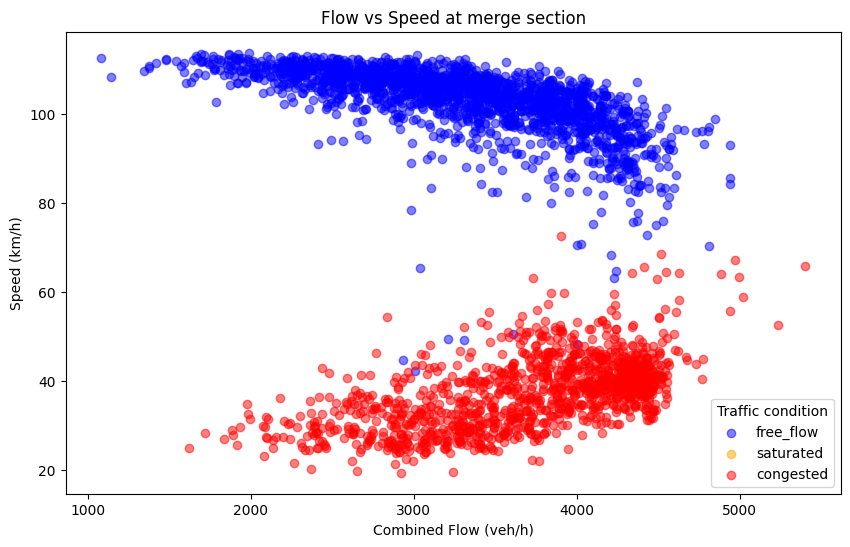

In [30]:
# free-flow, saturated and congestion colors
color_map = {'free_flow': 'blue', 'saturated': 'orange', 'congested': 'red'}

# create figure
plt.figure(figsize=(10, 6))

# plot each traffic condition
for condition, color in color_map.items():
    df_subset = df_data[df_data['merged_condition'] == condition]
    plt.scatter(df_subset[f'{road_section}_flow'], df_subset[f'{road_section}_speed'], color=color, label=condition, alpha=0.5)

# plot layout
plt.xlabel('Combined Flow (veh/h)')
plt.ylabel('Speed (km/h)')
plt.title('Flow vs Speed at merge section')
plt.legend(title="Traffic condition")

# show plot
plt.show()

In [26]:
saturated_flow_threshold = df_data.loc[df_data['merged_condition'] == 'saturated', f'{road_section}_flow'].mean()
congested_flow_threshold = df_data.loc[df_data['merged_condition'] == 'congested', f'{road_section}_flow'].mean()

print("Flow Thresholds at Merging Section:")
print(f"Saturated Flow Threshold: ~{int(saturated_flow_threshold)} veh/h")
print(f"Congested Flow Threshold: ~{int(congested_flow_threshold)} veh/h")

Flow Thresholds at Merging Section:


ValueError: cannot convert float NaN to integer

### 2. Select demand scenarios

In [ ]:
# select box of data points
min_density = 10
max_density = 30
min_flow = 3500
max_flow = 6000
density_column = 'BC_density'
flow_column = 'BC_flow'
df_new_fd_box = remove_fd_non_compliant_runs(df_new_fd, density_column, flow_column,
                                          min_density, max_density, min_flow, max_flow)

# show scatter plot for this box
show_fd_scatter_plot(df_new_fd_box, 'BC_density', 'BC_flow')

In [ ]:
# show Fd values for on-ramp lane
show_fd_scatter_plot(df_new_fd_box, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

In [ ]:
# select box of data points
min_density = 0
max_density = 40
min_flow = 0
max_flow = 2000
density_column = 'E2B.ONRAMP_density'
flow_column = 'E2B.ONRAMP_flow'
df_new_fd_box2 = remove_fd_non_compliant_runs(df_new_fd_box, density_column, flow_column,
                                           min_density, max_density, min_flow, max_flow)

# show Fd values for on-ramp lane
show_fd_scatter_plot(df_new_fd_box2, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

In [ ]:
# get range of demand variables
print("Main demand:", df_new_fd_box['main_demand'].min(), " - ", df_new_fd_box['main_demand'].max())
print("Ramp demand", df_new_fd_box['ramp_demand'].min(), " - ", df_new_fd_box['ramp_demand'].max())

In [ ]:
# show original data filtered for demand values
min_main = 2000
max_main = 4000
min_ramp = 100
max_ramp = 800
df_demand_box = remove_demand_non_compliant_runs(df_new_fd, min_main, max_main, min_ramp, max_ramp)

# show refined scatter plot
print('Merge lanes data:')
show_fd_scatter_plot(df_new_fd_box_r, 'BC_density', 'BC_flow')
print('On-ramp data:')
show_fd_scatter_plot(df_new_fd_box_r, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

### Conclusions
Demand...